# Entrenamiento: Modelo Cloud Binary Mask
Notebook para el entrenamiento del modelo "Cloud Binary Mask", cuyo trabajo es determinar cuando los pixeles representan nube.

Adrián Ramírez <br>
Contanto: felos@ciencias.unam.mx

### Preparando entorno

In [1]:
import os
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

DIR_SCRIPT  = os.getcwd()
DIR_REPO    = "/".join(DIR_SCRIPT.split("/")[:-2])
DIR_LIB     = f"{DIR_REPO}/lib"
DIR_MODELOS = f"{DIR_REPO}/Modelos" 
PATH_DATASET = f"{DIR_REPO}/gendata/Datasets/dataset.h5" 
PATH_DIC_NORM = None

sys.path.append(DIR_LIB)
sys.path.append(DIR_MODELOS)
import datasets
import modelos

RESOLUCION = 29

### Preparando los datos

In [2]:
lista_keys_X = ["4","6","13","14","Altura"]
lista_keys_y = ["CM"]

num_canales_input = len(lista_keys_X)

# Vaciamos el dataset en un diccionario.
dataset = {}
with h5py.File(PATH_DATASET,"r") as file:
    for key in file.keys():
        dataset[key] = file[key][:]

# Normalizamos los datos.
# POR AHORA NO HAY UN DICCIONARIO DE NORMALIZACIÓN UNIVERSAL...
# QUEDA PENDIENTE ESO. 
dataset,dic_norm = datasets.normalizarDataset(dataset)

# Obtenemos el número de archivos del que provienen los otros datasets.
num_archivos = dataset[lista_keys_X[0]].shape[0]

# Preparamos los datos de altura
if "Altura" in lista_keys_X:
    dataset["Altura"] = np.tile(dataset["Altura"],(num_archivos,1,1,1))

# Preparamos los datos de entrada.
X = []
for key in lista_keys_X: X.append(dataset[key])
X = np.stack(X,axis=4)
X = np.reshape(X,(-1,RESOLUCION,RESOLUCION,num_canales_input))
print(f"X.shape: {X.shape}")

# Preparamos los datos de salida
y = dataset["CM"]
y = np.reshape(y,(-1,RESOLUCION,RESOLUCION))
mask_nubes = y == 1
mask_clear = y == 0
y = np.stack([mask_nubes,mask_clear],axis=3)
print(f"y.shape: {y.shape}")

# Test 1: Separación correcta de los mask de segmentación.
suma_correcta = RESOLUCION*RESOLUCION
test = np.sum(y,axis=(1,2,3))
test = test != suma_correcta
test = np.sum(test)
assert test == 0, "Test1: No pasado."

# Randomizamos los datos
num_datos = len(X)
index_randomizados = np.arange(num_datos)
np.random.shuffle(index_randomizados)
X = X[index_randomizados]
y = y[index_randomizados]

# Separamos en train y test tomando el 20% de los datos.
index_separacion = np.floor(num_datos*0.2).astype(int)
X_train = X[index_separacion:]
X_test  = X[:index_separacion]
y_train = y[index_separacion:]
y_test  = y[:index_separacion]

print("")
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape : {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape : {y_test.shape}")

X.shape: (14400, 29, 29, 5)
y.shape: (14400, 29, 29, 2)

X_train.shape: (11520, 29, 29, 5)
X_test.shape : (2880, 29, 29, 5)
y_train.shape: (11520, 29, 29, 2)
y_test.shape : (2880, 29, 29, 2)


### Importamos modelo

In [3]:
modelo = modelos.Modelo_CBM()
modelo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29, 29, 5)]       0         
                                                                 
 dense (Dense)               (None, 29, 29, 5)         30        
                                                                 
 dense_1 (Dense)             (None, 29, 29, 5)         30        
                                                                 
 dense_2 (Dense)             (None, 29, 29, 5)         30        
                                                                 
 batch_normalization (BatchN  (None, 29, 29, 5)        20        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 29, 29, 15)        690       
                                                             

2022-07-27 09:44:53.956163: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-27 09:44:53.956249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-7566): /proc/driver/nvidia/version does not exist
2022-07-27 09:44:53.957771: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Entrenamos modelo

Epoch 1/20
360/360 [==============================] - 16s 40ms/step - loss: 0.3701 - accuracy: 0.8224 - val_loss: 0.6293 - val_accuracy: 0.6468
Epoch 2/20
360/360 [==============================] - 14s 39ms/step - loss: 0.2211 - accuracy: 0.9089 - val_loss: 0.2502 - val_accuracy: 0.9161
Epoch 3/20
360/360 [==============================] - 15s 40ms/step - loss: 0.1597 - accuracy: 0.9367 - val_loss: 0.1744 - val_accuracy: 0.9316
Epoch 4/20
360/360 [==============================] - 14s 39ms/step - loss: 0.1435 - accuracy: 0.9423 - val_loss: 0.6399 - val_accuracy: 0.7898
Epoch 5/20
360/360 [==============================] - 14s 39ms/step - loss: 0.1350 - accuracy: 0.9452 - val_loss: 0.1325 - val_accuracy: 0.9456
Epoch 6/20
360/360 [==============================] - 14s 39ms/step - loss: 0.1297 - accuracy: 0.9471 - val_loss: 0.1571 - val_accuracy: 0.9386
Epoch 7/20
360/360 [==============================] - 14s 39ms/step - loss: 0.1262 - accuracy: 0.9485 - val_loss: 0.2020 - val_accuracy:

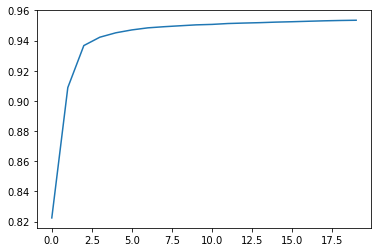

In [4]:
epochs = 20

modelo.compile(optimizer="rmsprop", loss="categorical_crossentropy",metrics=['accuracy'])

try:
    history = modelo.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_test,y_test),
        shuffle=False,
    )
except KeyboardInterrupt:
    print("Entrenamiento interumpido.")
    

plt.plot(history.history["accuracy"])

Text(0.5, 1.0, 'y inferencia round')

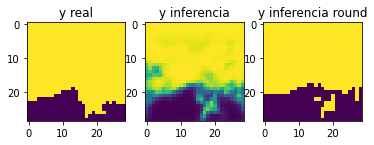

In [12]:
index = 60

modelo.train = False
x_prueba = X_test[index].reshape((1,RESOLUCION,RESOLUCION,num_canales_input))
y_real   = y_test[index,:,:,0].reshape((RESOLUCION,RESOLUCION))
y_inferencia= modelo(x_prueba).numpy().reshape((RESOLUCION,RESOLUCION))
y_inferencia_round = np.round(y_inferencia)
fig,ax = plt.subplots(1,3)
ax[0].imshow(y_real,vmin=0,vmax=1)
ax[0].set_title("y real")
ax[1].imshow(y_inferencia,vmin=0,vmax=1)
ax[1].set_title("y inferencia")
ax[2].imshow(y_inferencia_round,vmin=0,vmax=1)
ax[2].set_title("y inferencia round")